In [1]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MaxAbsScaler
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import warnings
from pprint import pprint
from sklearn.model_selection import ParameterGrid
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA
#from mlxtend.evaluate import feature_importance_permutation
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv("final_dataset2.csv",index_col=0)

In [3]:
df=df['1963-07':'2016-12']

In [4]:
df.drop(['PRC','VOL','SMB','HML','UMD'],axis=1,inplace=True)

In [ ]:
# total_rows=0
# for permn in df['Permno'].loc[df['ret']>=5].values:
#     subset=df[df['Permno']==permn]
#     total_rows=total_rows+len(subset)

# print(total_rows)

In [ ]:
# df=df[(~df['Permno'].isin(df['Permno'].loc[df['ret']>=5].values))]

# Analysis

In [5]:
df.reset_index(inplace=True)

In [6]:
df['Date'] = df['Date'].astype(str)

In [7]:
df['Date']=pd.to_datetime(df['Date']).dt.to_period('M')

In [8]:
x,y = df.drop(['ret'], axis = 1), df[['Permno','ret']]

In [9]:
y.index=x['Date']

In [10]:
y.index = y.index.shift(-1)

In [11]:
df_shifted = pd.merge(y, x, on = ['Date','Permno'], how = 'inner')
df_shifted.drop(['Permno'], axis = 1, inplace = True)
df_shifted.head()

,Date,ret,A2ME,AC,AT,ATO,BEME,Beta,C,CF,...,Resid_Var,RNA,ROA,ROE,S2P,SGA2S,Spread,ST_REV,SUV,Variance
0,1963-07,0.118581,2.279083,0.088069,255.4,5.589242,1.269299,0.832348,0.117854,-0.043307,...,0.000077,0.462347,0.031250,0.058388,2.039931,0.079090,0.013126,-0.001289,-0.127039,0.000116
1,1963-07,0.075514,1.163059,0.170219,316.3,4.892748,0.736371,1.044962,0.035409,-0.012833,...,0.000099,0.607491,0.059047,0.094291,1.056792,0.137738,0.018966,-0.038031,0.345807,0.000117
2,1963-07,0.056759,3.855506,-0.058373,505.0,7.831563,2.314999,1.312464,0.038614,0.024174,...,0.000168,0.142185,0.013400,0.019842,3.940251,0.130866,0.020311,-0.075472,-0.413066,0.000233
3,1963-07,0.052171,0.785296,0.009557,348.0,-6.640124,0.519480,1.251163,0.218391,0.096349,...,0.000158,-0.336505,0.091442,0.116149,1.448961,0.039573,0.015030,0.049342,0.815088,0.000183
4,1963-07,0.154022,1.394023,-0.053441,211.2,63.686745,0.716357,1.564608,0.244318,0.042218,...,0.000201,4.193624,0.053908,0.105422,2.505366,0.000000,0.017883,-0.032520,0.016746,0.000232


In [12]:
def plot_feature_importances(df):
    
    df = df.sort_values('importance', ascending = False).reset_index()  
    df['importance_normalized'] = df['importance'] / df['importance'].sum()  
    plt.figure(figsize = (10, 6))
    ax = plt.subplot() 
    ax.barh(list(reversed(list(df.index[:20]))), 
            df['importance_normalized'].head(20), 
            align = 'center',color='tab:blue')
    ax.set_yticks(list(reversed(list(df.index[:20]))))
    ax.set_yticklabels(df['feature'].head(20))
    plt.xlabel('Normalized Importance'); plt.title('Variable Importance')
    plt.show()
    
    #return df

In [13]:
def importance_features(model):
    Features = {'Name' :df_shifted.iloc[:,1:].columns.values, 'Value' : model[0].feature_importances_}
    Features = pd.DataFrame(Features)
    Features.set_index(Features.columns[0], inplace = True)
    
    for i in range(len(model)-1):
        features={'Name' : df_shifted.iloc[:,1:].columns.values, 'Value' : model[i].feature_importances_}
        features = pd.DataFrame(features)
        features.set_index(features.columns[0], inplace = True)
        Features=pd.merge(Features, features, on = 'Name', how = 'inner')
    
    Features=Features.T
    importance_values=np.mean(Features)
    Features=pd.DataFrame({'feature': df_shifted.iloc[:,1:].columns.values,'importance': importance_values})
    Features.reset_index(inplace=True,drop=True)
    
    plot_feature_importances(Features)

# Sample splitting

# Walk-forward approach

In [15]:
def score_r_squared(y_hat,y_true):

    SS_Residual = sum((y_true-y_hat)**2)
    SS_Total = sum((y_true)**2) # vs sum((y_validation-np.mean(y))**2) --> demeanining it
    r_squared = 1 - (float(SS_Residual))/SS_Total
    return r_squared

In [16]:
df_shifted=df_shifted.set_index(['Date'])

In [17]:
df_shifted.index=df_shifted.index.to_timestamp()

## Expanding window

In [18]:
def all_algo(df,algo,model_params):
    
    features=df.iloc[:,1:]
    outcome=df.iloc[:,0]
    recal_dates=features.resample('A',level='Date').mean().index[:-1]
    recal_dates.freq=None
    begin_dates = recal_dates
    end_dates = recal_dates[1:].append(pd.to_datetime(['2099-12-31']))
    
    models = pd.Series(index=recal_dates)
    predictions = pd.Series(index=features.index)
    sc = StandardScaler()
    training_scores=[]

    for i,date in (enumerate(recal_dates)):
        if i == 52:
            break
        else:
            X_train = features[begin_dates[0]:end_dates[i]]
            y_train = outcome[begin_dates[0]:end_dates[i]]
            X_test= features[begin_dates[i+1]:end_dates[i+1]]
            y_test= outcome[begin_dates[i+1]:end_dates[i+1]]
            X_train = sc.fit_transform(X_train)
            X_train= pd.DataFrame(X_train,columns=df.iloc[:,1:].columns)
            X_test= sc.transform(X_test)
            X_test=pd.DataFrame(X_test,index=features[begin_dates[i+1]:end_dates[i+1]].index)
            model = algo(**model_params)
            model.fit(X_train,y_train)
            training_scores.append(model.score(X_train,y_train))
            p = pd.Series(model.predict(X_test),index=X_test.index)
            predictions.loc[p.index[0]:p.index[-1]] = p
            models.loc[date] = model

        print("Training set using the first {} records, until {}"\
              .format(len(y_train),y_train.index.get_level_values('Date').max()))

    results=pd.DataFrame(predictions)
    results.rename(columns={0: 'y_pred'},inplace=True)
    results['y_true']=outcome
    results.dropna(inplace=True)

    return score_r_squared(results['y_pred'],results['y_true']), models

In [19]:
ols_all, _ =all_algo(df_shifted,LinearRegression,model_params={})

Training set using the first 3374 records, until 1964-12-01 00:00:00
Training set using the first 7487 records, until 1965-12-01 00:00:00
Training set using the first 12219 records, until 1966-12-01 00:00:00
Training set using the first 19129 records, until 1967-12-01 00:00:00
Training set using the first 29164 records, until 1968-12-01 00:00:00
Training set using the first 40742 records, until 1969-12-01 00:00:00
Training set using the first 53159 records, until 1970-12-01 00:00:00
Training set using the first 66491 records, until 1971-12-01 00:00:00
Training set using the first 80857 records, until 1972-12-01 00:00:00
Training set using the first 96385 records, until 1973-12-01 00:00:00
Training set using the first 112874 records, until 1974-12-01 00:00:00
Training set using the first 129855 records, until 1975-12-01 00:00:00
Training set using the first 145422 records, until 1976-12-01 00:00:00
Training set using the first 160708 records, until 1977-12-01 00:00:00
Training set using

In [20]:
ols_dic=Dict = {'Test R-Squared': ols_all} 

In [21]:
ols_dic=pd.DataFrame.from_dict([ols_dic])
ols_dic.rename(index={0: "OLS"},inplace=True)
ols_dic

,Test R-Squared
OLS,-1.110476e+20


In [22]:
enet_all,enet_models=all_algo(df_shifted,algo=ElasticNet,model_params={'alpha': 0.005,'l1_ratio' : 0.5})

Training set using the first 3374 records, until 1964-12-01 00:00:00
Training set using the first 7487 records, until 1965-12-01 00:00:00
Training set using the first 12219 records, until 1966-12-01 00:00:00
Training set using the first 19129 records, until 1967-12-01 00:00:00
Training set using the first 29164 records, until 1968-12-01 00:00:00
Training set using the first 40742 records, until 1969-12-01 00:00:00
Training set using the first 53159 records, until 1970-12-01 00:00:00
Training set using the first 66491 records, until 1971-12-01 00:00:00
Training set using the first 80857 records, until 1972-12-01 00:00:00
Training set using the first 96385 records, until 1973-12-01 00:00:00
Training set using the first 112874 records, until 1974-12-01 00:00:00
Training set using the first 129855 records, until 1975-12-01 00:00:00
Training set using the first 145422 records, until 1976-12-01 00:00:00
Training set using the first 160708 records, until 1977-12-01 00:00:00
Training set using

In [23]:
enet_dic=Dict = {'Test R-Squared': enet_all} 

In [24]:
enet_dic=pd.DataFrame.from_dict([enet_dic])
enet_dic.rename(index={0: "Elastic Net"},inplace=True)
enet_dic

,Test R-Squared
Elastic Net,0.003256


In [65]:
def importance_features_enet(model):

    Features = {'Name' : df_shifted.iloc[:,1:].columns.values, 'Value' : abs(model[0].coef_)}
    Features = pd.DataFrame(Features)
    Features.set_index(Features.columns[0], inplace = True)

    for i in range(len(model)-1):
        
        features={'Name' : df_shifted.iloc[:,1:].columns.values, 'Value' : abs(model[i].coef_)}
        features = pd.DataFrame(features)
        features.set_index(features.columns[0], inplace = True)
        Features=pd.merge(Features, features, on = 'Name', how = 'inner')

    Features=Features.T
    importance_values=np.mean(Features)
    Features=pd.DataFrame({'feature': df_shifted.iloc[:,1:].columns.values,'importance': importance_values})
    Features.reset_index(inplace=True,drop=True)

    plot_feature_importances(Features)


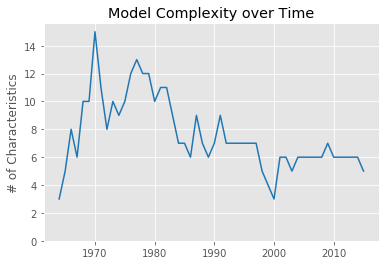

In [27]:
coefs=[]
for x in enet_models[:-1]:
    coefs.append(np.sum(x.coef_ != 0))
coefs=pd.DataFrame(coefs,index=enet_models[:-1].index)

plt.style.use('ggplot')
plt.plot(coefs.index,coefs,color='tab:blue')
plt.ylim(ymin=0)
plt.ylabel('# of Characteristics')
plt.title("Model Complexity over Time")
plt.show()

In [28]:
rf_all, rf_models=all_algo(df_shifted,algo=RandomForestRegressor,model_params={'n_estimators':10,'max_depth':2,'max_features':10})

Training set using the first 3374 records, until 1964-12-01 00:00:00
Training set using the first 7487 records, until 1965-12-01 00:00:00
Training set using the first 12219 records, until 1966-12-01 00:00:00
Training set using the first 19129 records, until 1967-12-01 00:00:00
Training set using the first 29164 records, until 1968-12-01 00:00:00
Training set using the first 40742 records, until 1969-12-01 00:00:00
Training set using the first 53159 records, until 1970-12-01 00:00:00
Training set using the first 66491 records, until 1971-12-01 00:00:00
Training set using the first 80857 records, until 1972-12-01 00:00:00
Training set using the first 96385 records, until 1973-12-01 00:00:00
Training set using the first 112874 records, until 1974-12-01 00:00:00
Training set using the first 129855 records, until 1975-12-01 00:00:00
Training set using the first 145422 records, until 1976-12-01 00:00:00
Training set using the first 160708 records, until 1977-12-01 00:00:00
Training set using

In [29]:
rf_dic=Dict = {'Test R-Squared': rf_all} 

In [30]:
rf_dic=pd.DataFrame.from_dict([rf_dic])
rf_dic.rename(index={0: "Random Forest"},inplace=True)
rf_dic

,Test R-Squared
Random Forest,0.003437


In [31]:
gbrt_all, gbrt_models =all_algo(df_shifted,GradientBoostingRegressor,model_params={'n_estimators':10,'max_depth':2,'max_features':10})

Training set using the first 3374 records, until 1964-12-01 00:00:00
Training set using the first 7487 records, until 1965-12-01 00:00:00
Training set using the first 12219 records, until 1966-12-01 00:00:00
Training set using the first 19129 records, until 1967-12-01 00:00:00
Training set using the first 29164 records, until 1968-12-01 00:00:00
Training set using the first 40742 records, until 1969-12-01 00:00:00
Training set using the first 53159 records, until 1970-12-01 00:00:00
Training set using the first 66491 records, until 1971-12-01 00:00:00
Training set using the first 80857 records, until 1972-12-01 00:00:00
Training set using the first 96385 records, until 1973-12-01 00:00:00
Training set using the first 112874 records, until 1974-12-01 00:00:00
Training set using the first 129855 records, until 1975-12-01 00:00:00
Training set using the first 145422 records, until 1976-12-01 00:00:00
Training set using the first 160708 records, until 1977-12-01 00:00:00
Training set using

In [32]:
gbrt_dic=Dict = {'Test R-Squared': gbrt_all} 

In [33]:
gbrt_dic=pd.DataFrame.from_dict([gbrt_dic])
gbrt_dic.rename(index={0: "GBRT"},inplace=True)
gbrt_dic

,Test R-Squared
GBRT,0.002209


### Random Forest hyperparametrization

In [34]:
def score_r_squared_val(model,X_sample):
    
    yhat = model.predict(X_sample)
    SS_Residual = sum((y_validation-yhat)**2)
    SS_Total = sum((y_validation)**2) # vs sum((y_validation-np.mean(y))**2) --> demeanining it
    r_squared = 1 - (float(SS_Residual))/SS_Total
    return r_squared

In [35]:
def hyperparam_rf():    
    
    models = pd.Series(index=recal_dates)
    predictions = pd.Series(index=features.index)
    sc = StandardScaler()

    for i,date in tqdm((enumerate(recal_dates))):
        if i == 52:
            break
        else:
            X_train = features[begin_dates[0]:end_dates[i]]
            y_train = outcome[begin_dates[0]:end_dates[i]]
            X_test= features[begin_dates[i+1]:end_dates[i+1]]
            y_test= outcome[begin_dates[i+1]:end_dates[i+1]]
            X_train = sc.fit_transform(X_train)
            X_train= pd.DataFrame(X_train,columns=df_shifted.iloc[:,1:].columns)
            X_test= sc.transform(X_test)
            X_test=pd.DataFrame(X_test,index=features[begin_dates[i+1]:end_dates[i+1]].index)
            if i>2:
                X_validation=features[end_dates[i-2]:end_dates[i-1]]
                y_validation=outcome[end_dates[i-2]:end_dates[i-1]]
                rf = RandomForestRegressor()
                grid = {'n_estimators':[50], 'max_depth': [2,4,6], 'max_features': [3,5,10,15], 'random_state': [42]}
                validation_scores = []
                for g in ParameterGrid(grid):
                    rf.set_params(**g)  # ** is "unpacking" the dictionary
                    rf.fit(X_train, y_train)
                    validation_scores.append(score_r_squared_val(rf, X_validation))
                    #validation_scores.append(rf.score(X_validation, y_validation))
                best_idx = np.argmax(validation_scores)
                rf=RandomForestRegressor(**ParameterGrid(grid)[best_idx])

            model = rf
            model.fit(X_train,y_train)
            p = pd.Series(model.predict(X_test),index=X_test.index)
            predictions.loc[p.index[0]:p.index[-1]] = p
            models.loc[date] = model

#         print("Training on the first {} records, until {}"\
#               .format(len(y_train),y_train.index.get_level_values('Date').max()))
        
    results=pd.DataFrame(predictions)
    results.rename(columns={0: 'y_pred'},inplace=True)
    results['y_true']=outcome
    results.dropna(inplace=True)

    return score_r_squared(results['y_pred'],results['y_true'])

### OLS-3

In [36]:
ols3_df_shifted=df_shifted[['ret','LME','BEME','r12_2']]

In [37]:
def all_pannel_ols3():  
    
    features_ols3=ols3_df_shifted.iloc[:,1:]
    outcome_ols3=ols3_df_shifted.iloc[:,0]
    recal_dates=features_ols3.resample('A',level='Date').mean().index[:-1]
    recal_dates.freq=None

    begin_dates = recal_dates
    end_dates = recal_dates[1:].append(pd.to_datetime(['2099-12-31']))


    models = pd.Series(index=recal_dates)
    predictions = pd.Series(index=features_ols3.index)
    sc = StandardScaler()

    for i,date in (enumerate(recal_dates)):
        if i == 52:
            break
        else:
            X_train = features_ols3[begin_dates[0]:end_dates[i]]
            y_train = outcome_ols3[begin_dates[0]:end_dates[i]]
            X_test= features_ols3[begin_dates[i+1]:end_dates[i+1]]
            y_test= outcome_ols3[begin_dates[i+1]:end_dates[i+1]]
            X_train = sc.fit_transform(X_train)
            X_test= sc.transform(X_test)
            X_test=pd.DataFrame(X_test,index=features_ols3[begin_dates[i+1]:end_dates[i+1]].index)
            model = LinearRegression()
            model.fit(X_train,y_train)
            p = pd.Series(model.predict(X_test),index=X_test.index)
            predictions.loc[p.index[0]:p.index[-1]] = p
            models.loc[date] = model

#         print("Training on the first {} records, until {}"\
#               .format(len(y_train),y_train.index.get_level_values('Date').max()))

    results=pd.DataFrame(predictions)
    results.rename(columns={0: 'y_pred'},inplace=True)
    results['y_true']=outcome_ols3
    results.dropna(inplace=True)   

    return score_r_squared(results['y_pred'],results['y_true']), models

In [38]:
ols3_all,ols3_models=all_pannel_ols3()

In [39]:
ols3_dic=Dict = {'Test R-Squared': ols3_all} 

In [40]:
ols3_dic=pd.DataFrame.from_dict([ols3_dic])
ols3_dic.rename(index={0: "OLS-3"},inplace=True)
ols3_dic

,Test R-Squared
OLS-3,0.002086


In [ ]:
# def extract_coefs(models):
#     coefs = pd.DataFrame()
#     for i,model in enumerate(models[:-1]):
#         model_coefs = pd.Series(model.coef_,index=['LME','BEME','r12_2']) #extract coefficients for model
#         model_coefs.name = models.index[i] # name it with the recalc date
#         coefs = pd.concat([coefs,model_coefs],axis=1)
#     return coefs.T 

In [ ]:
# extract_coefs(ols3_models).plot(title='Coefficients for Expanding Window Model')
# plt.show()

### Top and Bottom stocks

In [41]:
df_top=df_shifted.loc[df_shifted.index.unique()[0]][:int(0.10*len(df_shifted.loc[df_shifted.index.unique()[0]]))]
df_bottom=df_shifted.loc[df_shifted.index.unique()[0]][int(0.90*len(df_shifted.loc[df_shifted.index.unique()[0]])):]

for ele in df_shifted.index.unique()[1:]:

    df_temp=df_shifted.loc[ele]
    #ols3_df_shifted.loc[ele]=ols3_df_shifted.loc[ele].sort_values(by='LME',ascending=False)
    df_temp=df_temp.sort_values(by='LME',ascending=False)
    df_top=pd.concat([df_top,df_temp[:int(0.10*len(df_temp))]])
    df_bottom=pd.concat([df_bottom,df_temp[int(0.90*len(df_temp)):]])

In [42]:
def top_bottom(df,algo):    
    
    features=df.iloc[:,1:]
    outcome=df.iloc[:,0]
    recal_dates=features.resample('A',level='Date').mean().index[:-1]
    recal_dates.freq=None
    begin_dates = recal_dates
    end_dates = recal_dates[1:].append(pd.to_datetime(['2099-12-31']))

    models = pd.Series(index=recal_dates)
    predictions = pd.Series(index=features.index)
    sc = StandardScaler()

    for i,date in (enumerate(recal_dates)):
        if i == 52:
            break
        else:
            X_train = features[begin_dates[0]:end_dates[i]]
            y_train = outcome[begin_dates[0]:end_dates[i]]
            X_test= features[begin_dates[i+1]:end_dates[i+1]]
            y_test= outcome[begin_dates[i+1]:end_dates[i+1]]
            X_train = sc.fit_transform(X_train)
            X_test= sc.transform(X_test)
            X_test=pd.DataFrame(X_test,index=features[begin_dates[i+1]:end_dates[i+1]].index)
            model = algo 
            model.fit(X_train,y_train)
            p = pd.Series(model.predict(X_test),index=X_test.index)
            predictions.loc[p.index[0]:p.index[-1]] = p
            models.loc[date] = model

#         print("Training on the first {} records, through {}"\
#               .format(len(y_train),y_train.index.get_level_values('Date').max()))
        
    results=pd.DataFrame(predictions)
    results.rename(columns={0: 'y_pred'},inplace=True)
    results['y_true']=outcome
    results.dropna(inplace=True)

    return score_r_squared(results['y_pred'],results['y_true'])

In [43]:
ols_top=top_bottom(df_top,LinearRegression())
ols_bottom=top_bottom(df_bottom,LinearRegression())

In [44]:
enet_top=top_bottom(df_top,ElasticNet(alpha=0.01,l1_ratio=0.5))
enet_bottom=top_bottom(df_bottom,ElasticNet(alpha=0.01,l1_ratio=0.5))

In [45]:
rf_top=top_bottom(df_top,RandomForestRegressor(n_estimators=100,max_depth=2,max_features=10))
rf_bottom=top_bottom(df_bottom,RandomForestRegressor(n_estimators=100,max_depth=2,max_features=10))

In [46]:
gbrt_top=top_bottom(df_top,GradientBoostingRegressor(n_estimators=20,max_depth=2,max_features=10))
gbrt_bottom=top_bottom(df_bottom,GradientBoostingRegressor(n_estimators=20,max_depth=2,max_features=10))

### OLS 3

In [47]:
df_top=ols3_df_shifted.loc[ols3_df_shifted.index.unique()[0]][:int(0.10*len(ols3_df_shifted.loc[ols3_df_shifted.index.unique()[0]]))]
df_bottom=ols3_df_shifted.loc[ols3_df_shifted.index.unique()[0]][int(0.90*len(ols3_df_shifted.loc[ols3_df_shifted.index.unique()[0]])):]

for ele in ols3_df_shifted.index.unique()[1:]:

    df_temp=ols3_df_shifted.loc[ele]
    #ols3_df_shifted.loc[ele]=ols3_df_shifted.loc[ele].sort_values(by='LME',ascending=False)
    df_temp=df_temp.sort_values(by='LME',ascending=False)
    df_top=pd.concat([df_top,df_temp[:int(0.10*len(df_temp))]])
    df_bottom=pd.concat([df_bottom,df_temp[int(0.90*len(df_temp)):]])

In [48]:
def top_bottom_ols3(df):    
    
    features_ols3=df.iloc[:,1:]
    outcome_ols3=df.iloc[:,0]
    recal_dates=features_ols3.resample('A',level='Date').mean().index[:-1]
    recal_dates.freq=None
    begin_dates = recal_dates
    end_dates = recal_dates[1:].append(pd.to_datetime(['2099-12-31']))

    models = pd.Series(index=recal_dates)
    predictions = pd.Series(index=features_ols3.index)
    sc = StandardScaler()

    for i,date in (enumerate(recal_dates)):
        if i == 52:
            break
        else:
            X_train = features_ols3[begin_dates[0]:end_dates[i]]
            y_train = outcome_ols3[begin_dates[0]:end_dates[i]]
            X_test= features_ols3[begin_dates[i+1]:end_dates[i+1]]
            y_test= outcome_ols3[begin_dates[i+1]:end_dates[i+1]]
            X_train = sc.fit_transform(X_train)
            X_test= sc.transform(X_test)
            X_test=pd.DataFrame(X_test,index=features_ols3[begin_dates[i+1]:end_dates[i+1]].index)
            model = LinearRegression()
            model.fit(X_train,y_train)
            p = pd.Series(model.predict(X_test),index=X_test.index)
            predictions.loc[p.index[0]:p.index[-1]] = p
            models.loc[date] = model

#         print("Training on the first {} records, until {}"\
#               .format(len(y_train),y_train.index.get_level_values('Date').max()))
        
    results=pd.DataFrame(predictions)
    results.rename(columns={0: 'y_pred'},inplace=True)
    results['y_true']=outcome_ols3
    results.dropna(inplace=True)
    

    return score_r_squared(results['y_pred'],results['y_true']) 

In [49]:
ols3_top=top_bottom_ols3(df_top)
ols3_bottom=top_bottom_ols3(df_bottom)

In [50]:
all_scores=[]
for ele in (ols3_all,enet_all,rf_all,gbrt_all):
    all_scores.append(ele)

In [51]:
all_index = ['OLS-3', 'Elastic Net', 'Random Forest', 'GBRT']

In [52]:
all_scores=pd.DataFrame(all_scores,index=all_index,columns=['All'])

In [53]:
top_scores=[]
for ele in (ols3_top,enet_top,rf_top,gbrt_top):
    top_scores.append(ele)

In [54]:
bottom_scores=[]
for ele in (ols3_bottom,enet_bottom,rf_bottom,gbrt_bottom):
    bottom_scores.append(ele)

In [55]:
all_scores['Top']=top_scores
all_scores['Bottom']=bottom_scores

In [56]:
all_scores_bar = all_scores.reset_index().melt(id_vars=["index"])

In [57]:
all_scores_bar['value']=all_scores_bar['value']*100

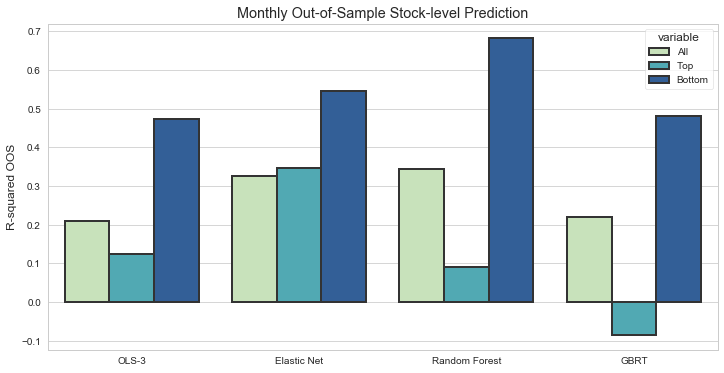

In [58]:
sns.set_style("whitegrid")
#plt.style.use('ggplot')
plt.figure(figsize = (12, 6))
ax=sns.barplot(x="index", y="value", hue="variable", palette='YlGnBu', data=all_scores_bar, linewidth=2.0,
 errcolor=".2", edgecolor=".2")
ax.set(xlabel="", ylabel='R-squared OOS')
plt.title('Monthly Out-of-Sample Stock-level Prediction')

plt.show()

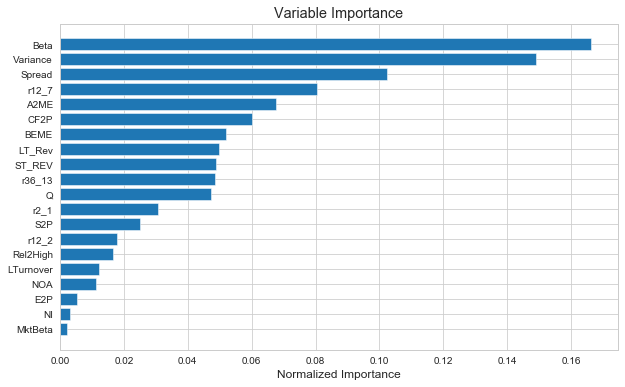

In [66]:
importance_features_enet(enet_models)

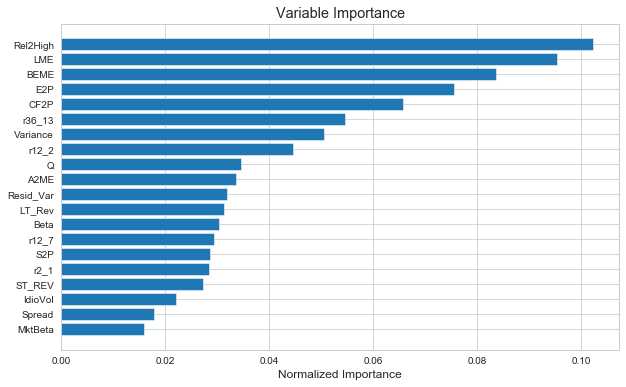

In [60]:
importance_features(rf_models)

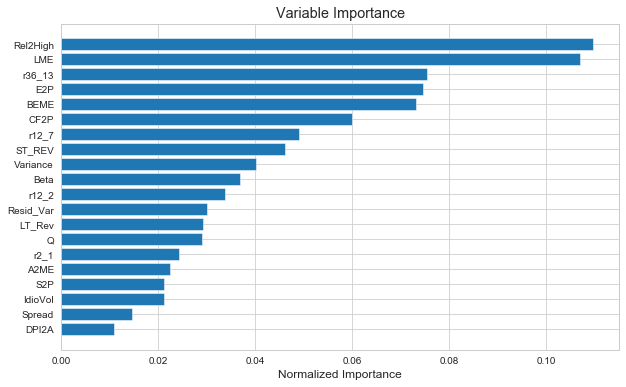

In [61]:
importance_features(gbrt_models)